In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm 
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import operator

In [18]:
def generate_simple_dataset(linspace, chanals, pandas=False):
    p1,p2,p3 = linspace
    v = np.linspace(p1, p2, p3)
    
    dataset = v
    for i in range(chanals-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 5*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_2class(t, noise=0.5):
    return 3*np.cos(5*pi*t) + 2*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_3class(t, noise=0.5):
    return 4*np.cos(5*pi*t) + 10*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def func_general(t, noise=0.5):
    return 9*np.cos(5*pi*t) + 10*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def get_cosinus_matrix(chanals, linspace):
    data_simple = generate_simple_dataset(linspace, chanals)
    vec = data_simple[0]
    
    size = (chanals, linspace[2])
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    

    data_simple = func_general(data_simple)
    data_simple[0] = data_simple[1]
    data_simple[65] = vec

    
    return data_simple

In [23]:
CHANALS = 128
LINSPACE = 0, 200, 20000
FIRST_N_FFT = 20
N_COMPONENTS_PCA = 60



data = get_cosinus_matrix(chanals=CHANALS, linspace=LINSPACE)
ICA = get_ICA(size=(CHANALS, CHANALS))
#Перемножаем ICA и EEG матрицы
matrix = np.matmul(ICA, data)
size = matrix.shape
class_ = class_ = size[1]//3

#Разбиваем на матрицы классов, чтоб проще было делить на семплы
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:data.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1)
sample_calss2 = get_sample(matrix_calss2)
sample_calss3 = get_sample(matrix_calss3)
#Преобразование Фурье

samples_fft = list(map(abs, fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3,
                                           first_n_elements=FIRST_N_FFT)))

len_class = len(sample_calss1)
sample_calss1_fft = samples_fft[:len_class]
sample_calss2_fft = samples_fft[len_class:len_class*2]
sample_calss3_fft = samples_fft[len_class*2:]

#Создание строк для датасета, из матрицы 128*20 -> в вектор 2560
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class, size[0] * FIRST_N_FFT)))
data_class_1['label'] = 1

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1.loc[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class, size[0] * FIRST_N_FFT)))
data_class_2['label'] = 2

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2.loc[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class, size[0] * FIRST_N_FFT)))
data_class_3['label'] = 3

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3.loc[i, :-1] = sample_calss3_fft_str[i]
    
    
data = pd.concat([data_class_1, data_class_2, data_class_3], axis=0)
print(data.shape)

100%|██████████| 34/34 [00:14<00:00,  2.38it/s]


(102, 2561)


In [24]:
## Понизим размерность до 60 компонент
PCA = PCA(n_components=N_COMPONENTS_PCA)

#Стандартизируем матрицу
Scaler = StandardScaler()
data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values

#Посмотрим важные признаки с помощью RF
rf = RandomForestClassifier()
rf.fit(data_pca, labels)

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

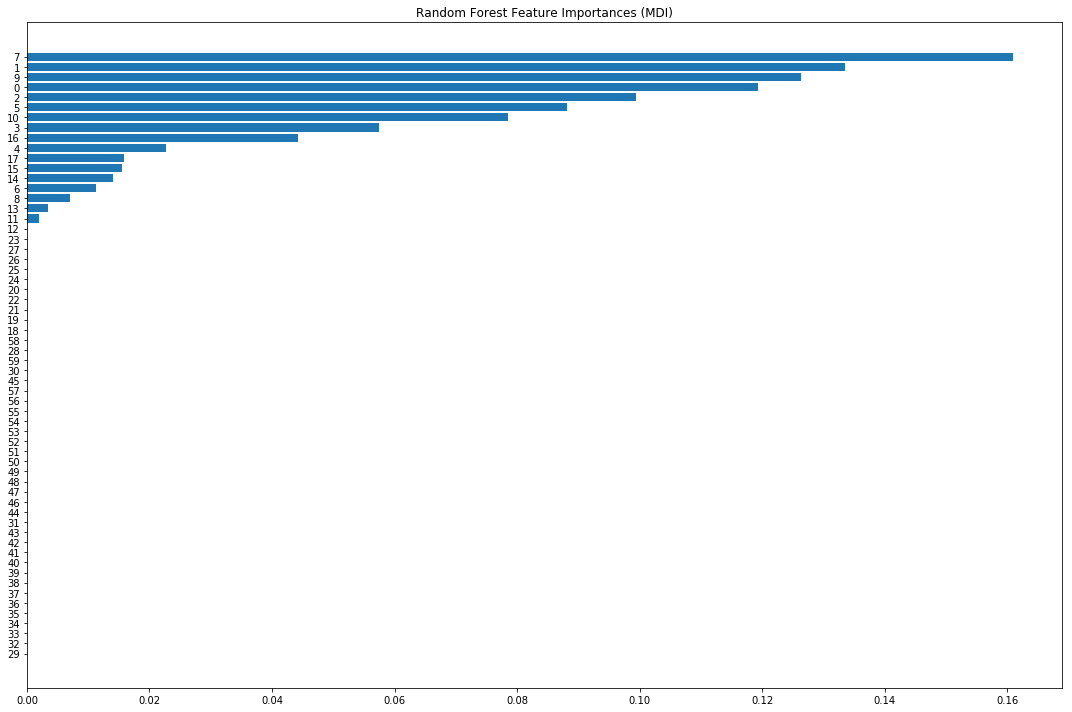

In [25]:
tree_feature_importances = (rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [26]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [27]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    features_good = str(features_good).strip('[]').split(' ')
    features_normal = str(features_normal).strip('[]').split(' ')
    features_bad = str(features_bad).strip('[]').split(' ')
    
    return features_good, features_normal, features_bad

In [28]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA).fit(train_features)
X_pc = model.transform(train_features)

features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [29]:
size

(128, 20000)

In [30]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    component_max_list = [(pd.DataFrame(model_pca.components_).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
    component_mean_list = [(pd.DataFrame(model_pca.components_).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
    for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value = model_pca.components_[component, feature]
            component_max = component_max_list[component]
            component_mean = component_mean_list[component]
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [31]:
d = features_imp_pca(train_features, model, X_pc, features_good, features_bad, features_normal)

100%|██████████| 2560/2560 [00:00<00:00, 7586.69it/s]


In [32]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(15)]

In [33]:
sorted_d[:15]

[('feature_643', 76),
 ('feature_644', 76),
 ('feature_647', 76),
 ('feature_650', 76),
 ('feature_651', 76),
 ('feature_652', 76),
 ('feature_653', 76),
 ('feature_654', 76),
 ('feature_655', 76),
 ('feature_657', 76),
 ('feature_658', 76),
 ('feature_660', 76),
 ('feature_661', 76),
 ('feature_662', 76),
 ('feature_665', 76)]

In [34]:
sorted_d[-15:]

[('feature_2531', -2),
 ('feature_2532', -2),
 ('feature_2534', -2),
 ('feature_2536', -2),
 ('feature_2537', -2),
 ('feature_2539', -2),
 ('feature_2547', -2),
 ('feature_2549', -2),
 ('feature_2552', -2),
 ('feature_2555', -2),
 ('feature_2556', -2),
 ('feature_2557', -2),
 ('feature_2558', -2),
 ('feature_2559', -2),
 ('feature_0', -17)]

In [362]:
with open('features_imp.txt', 'w') as fout:
    fout.write('name    weight')
    fout.write('\n')
    for i in sorted_d:
        fout.write(str(i[0]))
        fout.write(' ')
        fout.write(str(i[1]))
        fout.write('\n')

In [35]:
best_features

['feature_643',
 'feature_644',
 'feature_647',
 'feature_650',
 'feature_651',
 'feature_652',
 'feature_653',
 'feature_654',
 'feature_655',
 'feature_657',
 'feature_658',
 'feature_660',
 'feature_661',
 'feature_662',
 'feature_665']

In [36]:
train_features

array([[-0.47944639, -0.47928708, -0.47839328, ...,  0.58567951,
         0.5859093 ,  0.58537645],
       [-0.48165733, -0.48149772, -0.48060226, ...,  0.58243371,
         0.58266339,  0.5821308 ],
       [-0.483874  , -0.48371409, -0.48281696, ...,  0.57917571,
         0.57940528,  0.57887295],
       ...,
       [-1.15873515, -1.15874747, -1.15881526, ..., -0.34030177,
        -0.34037412, -0.34020635],
       [-2.44635766, -2.44668071, -2.44848939, ...,  0.64041054,
         0.63966731,  0.64139058],
       [-3.61867589, -3.61967757, -3.62529001, ..., -2.32009983,
        -2.32018981, -2.31998106]])

In [37]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [38]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in range(train_features.shape[0]):
    sample = pd.DataFrame(np.zeros((128, 20)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = 128

        
    for s in range(20):
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += 128

        if index_end > 2560:
            break

    old_table.append(sample.values)
  

In [39]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            

102it [00:00, 380.33it/s]


In [41]:
with open('FE_items.txt', 'w') as fout:
    fout.write('номер семпла, индекс, колонка (грубо говоря, адрес важной цифры)')
    fout.write('\n')
    fout.write('В семпле X в Y колонке, на Z индексе, какой-то важный сигнал и так далее')
    fout.write('\n')
    for i in FE_items:
        fout.write(str(i))
        fout.write('\n')

In [40]:
(FE_items)

[(0, 3, 5),
 (0, 4, 5),
 (0, 7, 5),
 (0, 10, 5),
 (0, 11, 5),
 (0, 12, 5),
 (0, 13, 5),
 (0, 14, 5),
 (0, 15, 5),
 (0, 17, 5),
 (0, 18, 5),
 (0, 20, 5),
 (0, 21, 5),
 (0, 22, 5),
 (0, 25, 5),
 (1, 3, 5),
 (1, 4, 5),
 (1, 7, 5),
 (1, 10, 5),
 (1, 11, 5),
 (1, 12, 5),
 (1, 13, 5),
 (1, 14, 5),
 (1, 15, 5),
 (1, 17, 5),
 (1, 18, 5),
 (1, 20, 5),
 (1, 21, 5),
 (1, 22, 5),
 (1, 25, 5),
 (2, 3, 5),
 (2, 4, 5),
 (2, 7, 5),
 (2, 10, 5),
 (2, 11, 5),
 (2, 12, 5),
 (2, 13, 5),
 (2, 14, 5),
 (2, 15, 5),
 (2, 17, 5),
 (2, 18, 5),
 (2, 20, 5),
 (2, 21, 5),
 (2, 22, 5),
 (2, 25, 5),
 (3, 3, 5),
 (3, 4, 5),
 (3, 7, 5),
 (3, 10, 5),
 (3, 11, 5),
 (3, 12, 5),
 (3, 13, 5),
 (3, 14, 5),
 (3, 15, 5),
 (3, 17, 5),
 (3, 18, 5),
 (3, 20, 5),
 (3, 21, 5),
 (3, 22, 5),
 (3, 25, 5),
 (4, 3, 5),
 (4, 4, 5),
 (4, 7, 5),
 (4, 10, 5),
 (4, 11, 5),
 (4, 12, 5),
 (4, 13, 5),
 (4, 14, 5),
 (4, 15, 5),
 (4, 17, 5),
 (4, 18, 5),
 (4, 20, 5),
 (4, 21, 5),
 (4, 22, 5),
 (4, 25, 5),
 (5, 3, 5),
 (5, 4, 5),
 (5, 7, 5),
 (5,